<h2>Load dữ liệu vào DataFrame</h2>

Đầu tiên, ta sẽ sử dụng pandas để load tập dữ liệu home_data.csv về dạng DataFrame.

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import linear_model
from sklearn.externals import joblib
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

def get_home_data():
    """Get home data, from local csv."""
    if os.path.exists("data/home_data.csv"):
        df = pd.read_csv("data/home_data.csv", index_col=0)

    return df

df = get_home_data()
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
7129300520,20141013T000000,221900,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
6414100192,20141209T000000,538000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
5631500400,20150225T000000,180000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2487200875,20141209T000000,604000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
1954400510,20150218T000000,510000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [2]:
df.shape

(21613, 20)

<h2>Lựa chọn thuộc tính và phân chia tập dữ liệu</h2>

Tập dữ liệu home_data có nhiều thuộc tính liên quan. Trong ví dụ này, ta sẽ sử dụng ba thuộc tính đơn giản là "bedrooms", "bathrooms",  và "grade" để dự đoán giá nhà. Sau đó, ta tiếp tục phân chia tập dữ liệu thành hai phần training (70%) và testing (30%). Sau cùng, ta thử lập biểu đồ mối quan hệ giữa ba thuộc tính này so với giá nhà để xem chúng có tạo ra một xu hướng nào không.


Features name: ['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']
Selected features: ['bedrooms', 'bathrooms', 'grade']


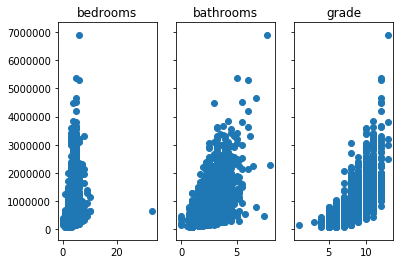

In [3]:
def plotting_features_vs_target(features, x, y):
    # define number of subplot
    num_feature = len(features)
    f, axes = plt.subplots(1, num_feature, sharey=True)

    # plotting
    for i in range(0, num_feature):
        axes[i].scatter(x[features[i]], y)
        axes[i].set_title(features[i])

    plt.show()

# features selection
features = list(["bedrooms", "bathrooms", "grade"])
print "Features name:", list(df.columns.values)
print "Selected features:", features
y = df["price"]
X = df[features]

# split data-set into training (70%) and testing set (30%)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# plotting features, target relationships
plotting_features_vs_target(features, x_train, y_train)

<h2>Huấn luyện và đánh giá theo phương pháp cơ bản</h2>

Về cơ bản, quá trình training mô hình của chúng ta sẽ hướng đến tối tiểu hoá hàm lỗi sau:

$$min_w ||Xw - y||_2^2 $$

Ta sử dụng scikit-learn (linear_model) để huấn luyện mô hình theo giải thuật <strong>Gradient Descent</strong>. Khi đã có được mô hình, ta sẽ sử dụng tập testing để đánh giá thông qua hàm score(). Hàm score() được định nghĩa như sau:

```
Returns the coefficient of determination R^2 of the prediction.
The coefficient R^2 is defined as (1 - u/v), where u is the regression
sum of squares ((y_true - y_pred) ** 2).sum() and v is the residual
sum of squares ((y_true - y_true.mean()) ** 2).sum().
Best possible score is 1.0 and it can be negative (because the
model can be arbitrarily worse). A constant model that always
predicts the expected value of y, disregarding the input features,
would get a R^2 score of 0.0.
```

In [10]:
"""
DEFAULT MODEL
"""
# training model
linear = linear_model.LinearRegression()
linear.fit(x_train, y_train)

# evaluating model
score_trained = linear.score(x_test, y_test)
print "Model scored:", score_trained

Model scored: 0.4536738526774685


<h2>Huấn luyện và đánh giá theo phương pháp Lasso (L1 regularization)</h2>

Regularization thường được dùng để giảm thiểu vấn đề liên quan đến overfitting/variance. Lasso sử dụng thêm tham số $\alpha$ để điều chỉnh lại quá trình fitting dữ liệu của mô hình. <strong>C</strong><span class="s1"><strong>oordinate Descent</strong> được áp dụng để huấn luyện mô hình.</span>

$$min_w ||Xw - y||_2^2 + \alpha||w||_2^2 $$

In [5]:
"""
LASSO MODEL
"""
# L1 regularization
lasso_linear = linear_model.Lasso(alpha=1.0)
lasso_linear.fit(x_train, y_train)

# evaluating L1 regularized model
score_lasso_trained = lasso_linear.score(x_test, y_test)
print "Lasso model scored:", score_lasso_trained

Lasso model scored: 0.4536737876567861


<h2>Huấn luyện và đánh giá theo phương pháp Ridge (L2 regularization)</h2>

Ridge sử dụng <span class="s1">Stochastic Average Gradient descent để huấn luyện mô hình thoả hàm lỗi được định nghĩa như bên dưới</span>

$$min_w \frac{1}{2n_{samples}} ||Xw - y||_2^2 + \alpha||w||_1 $$

In [6]:
"""
RIDGE MODEL
"""
# L2 regularization
ridge_linear = Ridge(alpha=1.0)
ridge_linear.fit(x_train, y_train)

# evaluating L2 regularized model
score_ridge_trained = ridge_linear.score(x_test, y_test)
print "Ridge model scored:", score_ridge_trained

Ridge model scored: 0.45367284849267886


Nếu dữ liệu và số lượng thuộc tính đủ lớn, ta có thể quan sát rõ tốc độ hội tụ của phương pháp Lasso nhanh hơn các phương pháp còn lại, nhờ vào cơ chế tính đạo hàm cho từng thuộc tính thay vì tính đạo hàm cùng lúc cho từng thuộc tính. Ridge sử dụng phương pháp Gradient Descent nhưng có áp dụng thêm cơ chế lựa chọn thuộc tính ngẫu nhiên để hy vọng đạt được kết quả hội tụ sớm. Cuối cùng, việc lựa chọn mô hình được dựa vào chỉ số đánh giá mô hình. Mô hình càng tốt thì model score càng gần đến 1.0.
<h2>Nâng bậc của mô hình tuyến tính</h2>

Nếu mô hình của chúng ta ở không gian 2 chiều thì hàm mục tiêu của chúng ta có dạng như sau:
$$\hat{y} (w, x) = w_0 + w_1x_1 + w_2x_2 $$
Nếu chúng ta muốn nâng bậc của mô hình thành bậc 2, nghĩa là ta chuyển đường thẳng thành đường cong Parabol thì mô hình của chúng ta sẽ có dạng như bên dưới:
$$\hat{y} (w, x) = w_0 + w_1x_1 + w_2x_2 + w_3x_1x_2 + w_4x_1^2 + w_5x_2^2 $$
Ta có thể thấy mô hình này vẫn là mô hình tuyến tính với
$$z = [x_1, x_2, x_1x_2, x_1^2, x_2^2]$$
Nếu ta đặt tên lại cho $x_1^2 = z_4, x_2^2 = z_5 $ thì mô hình của chúng ta có dạng:
$$\hat{y} (w, x) = w_0 + w_1x_1 + w_2x_2 + w_3x_1x_2 + w_4z_4 + w_5z_5 $$
Sử dụng PolynomialFeatures preprocessor ta có thể biến đổi dữ liệu X đầu vào lên bậc 2, 3, ... nhờ vào hàm fit_transform(). Giả sử $X = [x_1, x_2]$ thì sau khi nâng bậc ta có $X = [1, x_1, x_2, x_1^2, x_1x_2, x_2^2]$


In [7]:
"""
POLYNOMIAL REGRESSION
"""
poly_model = Pipeline([('poly', PolynomialFeatures(degree=2)),
                       ('linear', linear_model.LinearRegression(fit_intercept=False))])
poly_model = poly_model.fit(x_train, y_train)
score_poly_trained = poly_model.score(x_test, y_test)
print "Poly model scored:", score_poly_trained

Poly model scored: 0.5543841321089122


Ngoài ra, ta có thể lược bỏ các biến $x_i^n = x_i$ do các biến này có thể không hữu ích lắm trong một vài trường hợp và chỉ quan tâm đến $x_ix_j$ bằng cách thêm tham số interaction_only=True cho PolynomialFeatures.


In [8]:
poly_model = Pipeline([('poly', PolynomialFeatures(interaction_only=True, degree=2)),
                       ('linear', linear_model.LinearRegression(fit_intercept=False))])
poly_model = poly_model.fit(x_train, y_train)
score_poly_trained = poly_model.score(x_test, y_test)
print "Poly model (interaction only) scored:", score_poly_trained

Poly model (interaction only) scored: 0.546006877538587


<h2>Lưu lại mô hình cho ứng dụng</h2>

Ta có thể lưu lại mô hình đã được huấn luyện vào một file. Sau đó, ứng dụng có thể đọc và áp dụng mô hình này vào thực tế.


In [9]:
from sklearn.externals import joblib

# saving model
joblib.dump(linear, "models/linear_model_v1.pkl")

# loading model
clf = joblib.load("models/linear_model_v1.pkl")
predicted = clf.predict(x_test)
print "Predicted test:", predicted

Predicted test: [ 395607.4410409  1013878.95342482  410111.35733243 ...  632238.36304822
  334143.45895813  632238.36304822]


<em><strong>Nguồn tham khảo:</strong></em>
<ul>
	<li><a href="http://scikit-learn.org/stable/modules/linear_model.html">Scikit-learn: Linear model</a></li>
	<li><a href="http://www.stat.ucdavis.edu/~chohsieh/teaching/ECS289G_Fall2015/lecture3.pdf">Gradient Descent vs Coordinate Descent</a></li>
	<li><a href="http://scikit-learn.org/stable/modules/linear_model.html#polynomial-regression-extending-linear-models-with-basis-functions">Polynomial regression: extending linear models with basis functions</a></li>
	<li>
<p class="p1"><a href="https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-ridge-lasso-regression-python/"><span class="s1">A Complete Tutorial on Ridge and Lasso Regression in Python</span></a></p>
</li>
</ul>